# Hyperband using MNIST

Model architecture based on https://keras.io/examples/mnist_transfer_cnn/ 

To load images into tables we use the script called <em>madlib_image_loader.py</em> located at https://github.com/apache/madlib-site/tree/asf-site/community-artifacts/Deep-learning which uses the Python Imaging Library so supports multiple formats http://www.pythonware.com/products/pil/

## Table of contents
<a href="#import_libraries">1. Import libraries</a>

<a href="#load_and_prepare_data">2. Load and prepare data</a>

<a href="#image_preproc">3. Call image preprocessor</a>

<a href="#define_and_load_model">4. Define and load model architecture</a>

<a href="#hyperband">5. Hyperband</a>

<a href="#plot">6. Plot results</a>

In [1]:
%load_ext sql

/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/fmcquillan/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


In [2]:
# Greenplum Database 5.x on GCP (PM demo machine) - direct external IP access
#%sql postgresql://gpadmin@34.67.65.96:5432/madlib

# Greenplum Database 5.x on GCP - via tunnel
%sql postgresql://gpadmin@localhost:8000/madlib
        
# PostgreSQL local
#%sql postgresql://fmcquillan@localhost:5432/madlib

# psycopg2 connection
import psycopg2 as p2
#conn = p2.connect('postgresql://fmcquillan@localhost:5432/madlib')
conn = p2.connect('postgresql://gpadmin@localhost:8000/madlib')
cur = conn.cursor()

In [3]:
%sql select madlib.version();
#%sql select version();

1 rows affected.


version
"MADlib version: 1.17-dev, git revision: rel/v1.16-47-g5a1717e, cmake configuration time: Tue Nov 19 01:02:39 UTC 2019, build type: release, build system: Linux-3.10.0-957.27.2.el7.x86_64, C compiler: gcc 4.8.5, C++ compiler: g++ 4.8.5"


<a id="import_libraries"></a>
# 1.  Import libraries
From https://keras.io/examples/mnist_transfer_cnn/ import libraries and define some params

In [4]:
from __future__ import print_function

import datetime
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

now = datetime.datetime.now

#batch_size = 128
num_classes = 10
#epochs = 5

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
filters = 32
# size of pooling area for max pooling
pool_size = 2
# convolution kernel size
kernel_size = 3

if K.image_data_format() == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


Others needed in this workbook

In [5]:
import pandas as pd
import numpy as np

<a id="load_and_prepare_data"></a>
# 2.  Load and prepare data

First load MNIST data from Keras, consisting of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

In [32]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# reshape to match model architecture
print(x_test.shape)
x_train = x_train.reshape(len(x_train), *input_shape)
x_test = x_test.reshape(len(x_test), *input_shape)
print(x_test.shape)

(10000, 28, 28)
(10000, 28, 28, 1)


Load datasets into tables using image loader scripts called <em>madlib_image_loader.py</em> located at https://github.com/apache/madlib-site/tree/asf-site/community-artifacts/Deep-learning

In [33]:
# MADlib tools directory
import sys
import os
madlib_site_dir = '/Users/fmcquillan/Documents/Product/MADlib/Demos/data'
sys.path.append(madlib_site_dir)

# Import image loader module
from madlib_image_loader import ImageLoader, DbCredentials

In [34]:
# Specify database credentials, for connecting to db
db_creds = DbCredentials(user='gpadmin',
                         host='localhost',
                         port='8000',
                         password='')

In [35]:
# Initialize ImageLoader (increase num_workers to run faster)
iloader = ImageLoader(num_workers=5, db_creds=db_creds)

In [36]:
# Drop tables
%sql DROP TABLE IF EXISTS train_mnist, test_mnist

# Save images to temporary directories and load into database
iloader.load_dataset_from_np(x_train, y_train, 'train_mnist', append=False)
iloader.load_dataset_from_np(x_test, y_test, 'test_mnist', append=False)

Done.
MainProcess: Connected to madlib db.
Executing: CREATE TABLE train_mnist (id SERIAL, x REAL[], y TEXT)
CREATE TABLE
Created table train_mnist in madlib db
Spawning 5 workers...
Initializing PoolWorker-11 [pid 34068]
PoolWorker-11: Created temporary directory /tmp/madlib_RbuQlbqxI5
Initializing PoolWorker-12 [pid 34069]
PoolWorker-12: Created temporary directory /tmp/madlib_tEyH9GMFGV
Initializing PoolWorker-13 [pid 34070]
PoolWorker-13: Created temporary directory /tmp/madlib_TyYs4viAVD
Initializing PoolWorker-14 [pid 34071]
Initializing PoolWorker-15 [pid 34072]
PoolWorker-14: Created temporary directory /tmp/madlib_KTwnncRsaq
PoolWorker-15: Created temporary directory /tmp/madlib_jtG9zAC8HU
PoolWorker-11: Connected to madlib db.
PoolWorker-13: Connected to madlib db.
PoolWorker-14: Connected to madlib db.
PoolWorker-12: Connected to madlib db.
PoolWorker-15: Connected to madlib db.
PoolWorker-11: Wrote 1000 images to /tmp/madlib_RbuQlbqxI5/train_mnist0000.tmp
PoolWorker-14: Wro

PoolWorker-12: Wrote 1000 images to /tmp/madlib_tEyH9GMFGV/train_mnist0011.tmp
PoolWorker-15: Loaded 1000 images into train_mnist
PoolWorker-13: Loaded 1000 images into train_mnist
PoolWorker-11: Loaded 1000 images into train_mnist
PoolWorker-14: Loaded 1000 images into train_mnist
PoolWorker-15: Wrote 1000 images to /tmp/madlib_jtG9zAC8HU/train_mnist0011.tmp
PoolWorker-12: Loaded 1000 images into train_mnist
PoolWorker-15: Loaded 1000 images into train_mnist
PoolWorker-11: Removed temporary directory /tmp/madlib_RbuQlbqxI5
PoolWorker-15: Removed temporary directory /tmp/madlib_jtG9zAC8HU
PoolWorker-12: Removed temporary directory /tmp/madlib_tEyH9GMFGV
PoolWorker-13: Removed temporary directory /tmp/madlib_TyYs4viAVD
PoolWorker-14: Removed temporary directory /tmp/madlib_KTwnncRsaq
Done!  Loaded 60000 images in 45.7068669796s
5 workers terminated.
MainProcess: Connected to madlib db.
Executing: CREATE TABLE test_mnist (id SERIAL, x REAL[], y TEXT)
CREATE TABLE
Created table test_mnist

<a id="image_preproc"></a>
# 3. Call image preprocessor

Transforms from one image per row to multiple images per row for batch optimization.  Also normalizes and one-hot encodes.

Training dataset

In [37]:
%%sql
DROP TABLE IF EXISTS train_mnist_packed, train_mnist_packed_summary;

SELECT madlib.training_preprocessor_dl('train_mnist',             -- Source table
                                       'train_mnist_packed',      -- Output table
                                       'y',                       -- Dependent variable
                                       'x',                       -- Independent variable
                                        1000,                     -- Buffer size
                                        255                       -- Normalizing constant
                                        );

SELECT * FROM train_mnist_packed_summary;

Done.
1 rows affected.
1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes
train_mnist,train_mnist_packed,y,x,text,"[u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9']",1000,255.0,10


Test dataset

In [39]:
%%sql
DROP TABLE IF EXISTS test_mnist_packed, test_mnist_packed_summary;

SELECT madlib.validation_preprocessor_dl('test_mnist',              -- Source table
                                         'test_mnist_packed',       -- Output table
                                         'y',                       -- Dependent variable
                                         'x',                       -- Independent variable
                                         'train_mnist_packed'       -- Training preproc table
                                        );

SELECT * FROM test_mnist_packed_summary;

Done.
1 rows affected.
1 rows affected.


source_table,output_table,dependent_varname,independent_varname,dependent_vartype,class_values,buffer_size,normalizing_const,num_classes
test_mnist,test_mnist_packed,y,x,text,"[u'0', u'1', u'2', u'3', u'4', u'5', u'6', u'7', u'8', u'9']",5000,255.0,10


<a id="define_and_load_model"></a>
# 4. Define and load model architecture

Model with feature and classification layers trainable

In [6]:
# define two groups of layers: feature (convolutions) and classification (dense)
feature_layers = [
    Conv2D(filters, kernel_size,
           padding='valid',
           input_shape=input_shape),
    Activation('relu'),
    Conv2D(filters, kernel_size),
    Activation('relu'),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.25),
    Flatten(),
]

classification_layers = [
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_classes),
    Activation('softmax')
]

# create complete model
model = Sequential(feature_layers + classification_layers)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
__________

Load into model architecture table using psycopg2

In [7]:
%sql DROP TABLE IF EXISTS model_arch_table_mnist;
query = "SELECT madlib.load_keras_model('model_arch_table_mnist', %s, NULL, %s)"
cur.execute(query,[model.to_json(), "feature + classification layers trainable"])
conn.commit()

# check model loaded OK
%sql SELECT model_id, name FROM model_arch_table_mnist;

Done.
1 rows affected.


model_id,name
1,feature + classification layers trainable


<a id="hyperband"></a>
# 5.  Hyperband

Create tables

In [8]:
%%sql
-- overall results table
DROP TABLE IF EXISTS results_mnist;
CREATE TABLE results_mnist ( 
                      model_id INTEGER, 
                      compile_params TEXT,
                      fit_params TEXT, 
                      model_type TEXT, 
                      model_size DOUBLE PRECISION, 
                      metrics_elapsed_time DOUBLE PRECISION[], 
                      metrics_type TEXT[], 
                      training_metrics_final DOUBLE PRECISION, 
                      training_loss_final DOUBLE PRECISION, 
                      training_metrics DOUBLE PRECISION[], 
                      training_loss DOUBLE PRECISION[], 
                      validation_metrics_final DOUBLE PRECISION, 
                      validation_loss_final DOUBLE PRECISION, 
                      validation_metrics DOUBLE PRECISION[], 
                      validation_loss DOUBLE PRECISION[], 
                      model_arch_table TEXT, 
                      num_iterations INTEGER, 
                      start_training_time TIMESTAMP, 
                      end_training_time TIMESTAMP,
                      s INTEGER, 
                      n INTEGER, 
                      r INTEGER,
                      run_id SERIAL
                     );

-- model selection table
DROP TABLE IF EXISTS mst_table_hb_mnist;
CREATE TABLE mst_table_hb_mnist (
                           mst_key SERIAL, 
                           model_id INTEGER, 
                           compile_params VARCHAR, 
                           fit_params VARCHAR
                          );

-- model selection summary table
DROP TABLE IF EXISTS mst_table_hb_mnist_summary;
CREATE TABLE mst_table_hb_mnist_summary (model_arch_table VARCHAR);
INSERT INTO mst_table_hb_mnist_summary VALUES ('model_arch_table_mnist');

Done.
Done.
Done.
Done.
Done.
Done.
1 rows affected.


[]

Table names

In [9]:
results_table = 'results_mnist'

output_table = 'mnist_multi_model'
output_table_info = '_'.join([output_table, 'info'])
output_table_summary = '_'.join([output_table, 'summary'])

mst_table = 'mst_table_hb_mnist'
mst_table_summary = '_'.join([mst_table, 'summary'])

model_arch_table = 'model_arch_library_mnist'

Pretty print run schedule

In [10]:
import numpy as np
from math import log, ceil

#input
max_iter = 9  # maximum iterations/epochs per configuration
eta = 3  # defines downsampling rate (default=3)

logeta = lambda x: log(x)/log(eta)
s_max = int(logeta(max_iter))  # number of unique executions of Successive Halving (minus one)
B = (s_max+1)*max_iter  # total number of iterations (without reuse) per execution of Succesive Halving (n,r)

#echo output
print ("max_iter = " + str(max_iter))
print ("eta = " + str(eta))
print ("B = " + str(s_max+1) + "*max_iter = " + str(B))

sum_leaf_n_i = 0 # count configurations at leaf nodes across all s

#### Begin Finite Horizon Hyperband outlerloop. Repeat indefinitely.
for s in reversed(range(s_max+1)):
    
    print (" ")
    print ("s=" + str(s))
    print ("n_i      r_i")
    print ("------------")
    counter = 0
    
    n = int(ceil(int(B/max_iter/(s+1))*eta**s)) # initial number of configurations
    r = max_iter*eta**(-s) # initial number of iterations to run configurations for

    #### Begin Finite Horizon Successive Halving with (n,r)
    #T = [ get_random_hyperparameter_configuration() for i in range(n) ] 
    for i in range(s+1):
        # Run each of the n_i configs for r_i iterations and keep best n_i/eta
        n_i = n*eta**(-i)
        r_i = r*eta**(i)
        
        print (str(n_i) + "     " + str (r_i))
        
        # check if leaf node for this s
        if counter == s:
            sum_leaf_n_i += n_i
        counter += 1
        
        #val_losses = [ run_then_return_val_loss(num_iters=r_i,hyperparameters=t) for t in T ]
        #T = [ T[i] for i in argsort(val_losses)[0:int( n_i/eta )] ]
    #### End Finite Horizon Successive Halving with (n,r)

print (" ")
print ("sum of configurations at leaf nodes across all s = " + str(sum_leaf_n_i))
print ("(if have more workers than this, they may not be 100% busy)")

max_iter = 9
eta = 3
B = 3*max_iter = 27
 
s=2
n_i      r_i
------------
9     1.0
3.0     3.0
1.0     9.0
 
s=1
n_i      r_i
------------
3     3.0
1.0     9.0
 
s=0
n_i      r_i
------------
3     9
 
sum of configurations at leaf nodes across all s = 5.0
(if have more workers than this, they may not be 100% busy)


Hyperband 

In [11]:
import numpy as np

from random import random
from math import log, ceil
from time import time, ctime


class Hyperband:
    
    def __init__( self, get_params_function, try_params_function ):
        self.get_params = get_params_function
        self.try_params = try_params_function

        self.max_iter = 9  # maximum iterations per configuration
        self.eta = 3        # defines configuration downsampling rate (default = 3)

        self.logeta = lambda x: log( x ) / log( self.eta )
        self.s_max = int( self.logeta( self.max_iter ))
        self.B = ( self.s_max + 1 ) * self.max_iter

        self.results = []    # list of dicts
        self.counter = 0
        self.best_loss = np.inf
        self.best_counter = -1

    # can be called multiple times
    def run( self, skip_last = 0, dry_run = False ):

        for s in reversed( range( self.s_max + 1 )):
            
            # initial number of configurations
            n = int( ceil( self.B / self.max_iter / ( s + 1 ) * self.eta ** s ))

            # initial number of iterations per config
            r = self.max_iter * self.eta ** ( -s )
            
            print ("s = ", s)
            print ("n = ", n)
            print ("r = ", r)

            # n random configurations
            T = self.get_params(n) # what to return from function if anything?
            
            for i in range(( s + 1 ) - int( skip_last )): # changed from s + 1

                # Run each of the n configs for <iterations>
                # and keep best (n_configs / eta) configurations

                n_configs = n * self.eta ** ( -i )
                n_iterations = r * self.eta ** ( i )

                print ("\n*** {} configurations x {:.1f} iterations each".format(
                    n_configs, n_iterations ))
                
                # multi-model training
                U = self.try_params(s, n_configs, n_iterations) # what to return from function if anything?

                # select a number of best configurations for the next loop
                # filter out early stops, if any
                # drop from model selection table, model table and info table to keep all in sync
                k = int( n_configs / self.eta)
                
                # prune mst_table for next try
                %sql DELETE FROM $mst_table WHERE mst_key NOT IN (SELECT mst_key FROM $output_table_info ORDER BY validation_loss_final ASC LIMIT $k::INT);

        #return self.results
        
        return

In [12]:
def get_params(n):
    
    from sklearn.model_selection import ParameterSampler
    from scipy.stats.distributions import uniform
    import numpy as np
    
    # model architecture
    model_id = [1]

    # compile params
    # loss function
    loss = ['categorical_crossentropy']
    # optimizer
    optimizer = ['Adam', 'SGD']
    # learning rate (sample on log scale here not in ParameterSampler)
    lr_range = [0.001, 0.1]
    lr = 10**np.random.uniform(np.log10(lr_range[0]), np.log10(lr_range[1]), n)
    # metrics
    metrics = ['accuracy']

    # fit params
    # batch size
    batch_size = [64, 128]
    # epochs
    epochs = [1]

    # create random param list
    param_grid = {
        'model_id': model_id,
        'loss': loss,
        'optimizer': optimizer,
        'lr': lr,
        'metrics': metrics,
        'batch_size': batch_size,
        'epochs': epochs
    }
    param_list = list(ParameterSampler(param_grid, n_iter=n))
    
    for params in param_list:

        model_id = str(params.get("model_id"))
        compile_params = "$$loss='" + str(params.get("loss")) + "',optimizer='" + str(params.get("optimizer")) + "(lr=" + str(params.get("lr")) + ")',metrics=['" + str(params.get("metrics")) + "']$$" 
        fit_params = "$$batch_size=" + str(params.get("batch_size")) + ",epochs=" + str(params.get("epochs")) + "$$"  
        row_content = "(" + model_id + ", " + compile_params + ", " + fit_params + ");"
        
        %sql INSERT INTO $mst_table (model_id, compile_params, fit_params) VALUES $row_content
    
    return

In [13]:
def try_params(s, n_configs, n_iterations):
    
    # multi-model fit
    # TO DO:  use warm start to continue from where left off after if not 1st time thru for this s value
    %sql DROP TABLE IF EXISTS $output_table, $output_table_summary, $output_table_info;
    
    # passing vars as madlib args does not work???
    #%sql SELECT madlib.madlib_keras_fit_multiple_model('train_mnist_packed', $output_table, $mst_table, $n_iterations::INT, 0);
    %sql SELECT madlib.madlib_keras_fit_multiple_model('train_mnist_packed', 'mnist_multi_model', 'mst_table_hb_mnist', $n_iterations::INT, 0, 'test_mnist_packed');
   
    # save results
    %sql DROP TABLE IF EXISTS temp_results;
    %sql CREATE TABLE temp_results AS (SELECT * FROM $output_table_info);
    %sql ALTER TABLE temp_results DROP COLUMN mst_key, ADD COLUMN model_arch_table TEXT, ADD COLUMN num_iterations INTEGER, ADD COLUMN start_training_time TIMESTAMP, ADD COLUMN end_training_time TIMESTAMP, ADD COLUMN s INTEGER, ADD COLUMN n INTEGER, ADD COLUMN r INTEGER;
    %sql UPDATE temp_results SET model_arch_table = (SELECT model_arch_table FROM $output_table_summary), num_iterations = (SELECT num_iterations FROM iris_multi_model_summary), start_training_time = (SELECT start_training_time FROM iris_multi_model_summary), end_training_time = (SELECT end_training_time FROM iris_multi_model_summary), s = $s, n = $n_configs, r = $n_iterations;
    %sql INSERT INTO $results_table (SELECT * FROM temp_results);

    return

In [ ]:
hp = Hyperband( get_params, try_params )
results = hp.run()

s =  2
n =  9
r =  1.0
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.

*** 9 configurations x 1.0 iterations each
Done.


<a id="plot"></a>
# 6. Plot results

In [62]:
%matplotlib notebook
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import seaborn as sns
sns.set_palette(sns.color_palette("hls", 20))
plt.rcParams.update({'font.size': 12})
pd.set_option('display.max_colwidth', -1)

7 rows affected.


<IPython.core.display.Javascript object>


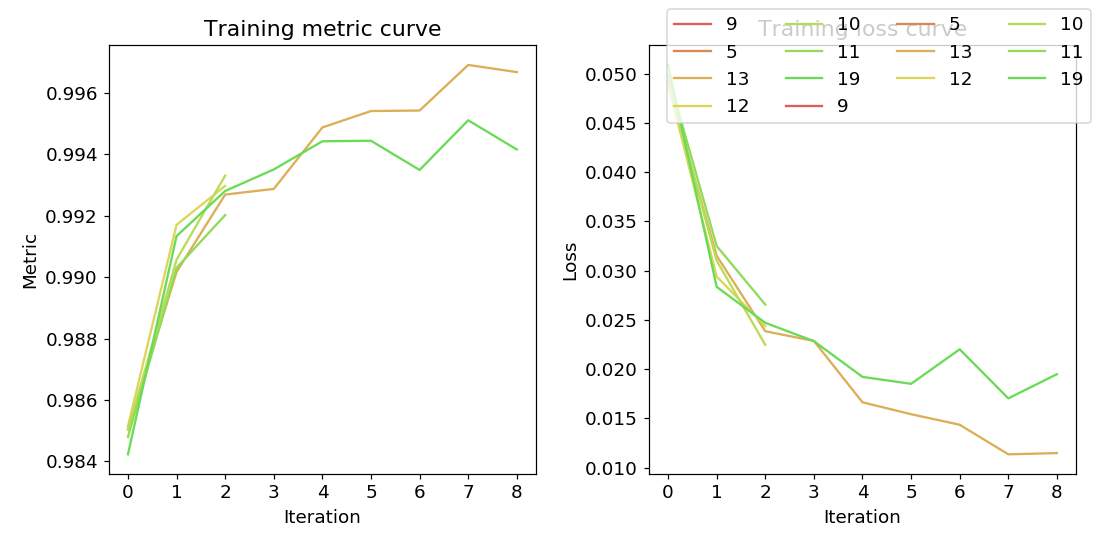

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


In [68]:
#df_results = %sql SELECT * FROM $results_table ORDER BY run_id;
df_results = %sql SELECT * FROM $results_table ORDER BY training_loss ASC LIMIT 7;
df_results = df_results.DataFrame()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for run_id in df_results['run_id']:
    df_output_info = %sql SELECT training_metrics,training_loss FROM $results_table WHERE run_id = $run_id
    df_output_info = df_output_info.DataFrame()
    training_metrics = df_output_info['training_metrics'][0]
    training_loss = df_output_info['training_loss'][0]
    X = range(len(training_metrics))
    
    ax_metric = axs[0]
    ax_loss = axs[1]
    ax_metric.set_xticks(X[::1])
    ax_metric.plot(X, training_metrics, label=run_id)
    ax_metric.set_xlabel('Iteration')
    ax_metric.set_ylabel('Metric')
    ax_metric.set_title('Training metric curve')

    ax_loss.set_xticks(X[::1])
    ax_loss.plot(X, training_loss, label=run_id)
    ax_loss.set_xlabel('Iteration')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Training loss curve')
    
fig.legend(ncol=4)
fig.tight_layout()
# fig.savefig('./lc_keras_fit.png', dpi = 300)

5 rows affected.


<IPython.core.display.Javascript object>


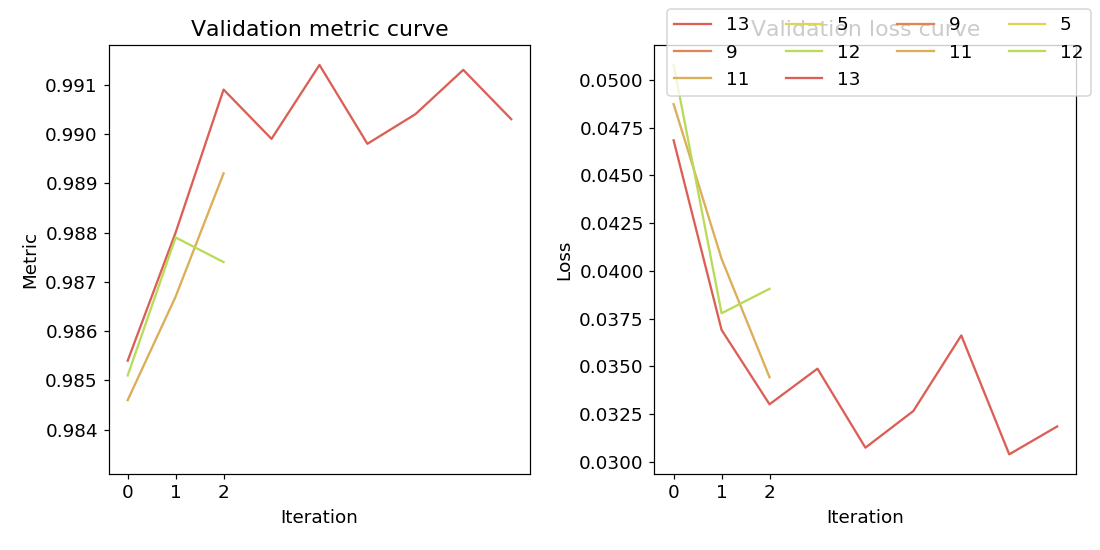

1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.
1 rows affected.


In [72]:
#df_results = %sql SELECT * FROM $results_table ORDER BY run_id;
df_results = %sql SELECT * FROM $results_table ORDER BY validation_loss ASC LIMIT 5;
df_results = df_results.DataFrame()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for run_id in df_results['run_id']:
    df_output_info = %sql SELECT validation_metrics,validation_loss FROM $results_table WHERE run_id = $run_id
    df_output_info = df_output_info.DataFrame()
    validation_metrics = df_output_info['validation_metrics'][0]
    validation_loss = df_output_info['validation_loss'][0]
    X = range(len(validation_metrics))
    
    ax_metric = axs[0]
    ax_loss = axs[1]
    ax_metric.set_xticks(X[::1])
    ax_metric.plot(X, validation_metrics, label=run_id)
    ax_metric.set_xlabel('Iteration')
    ax_metric.set_ylabel('Metric')
    ax_metric.set_title('Validation metric curve')

    ax_loss.set_xticks(X[::1])
    ax_loss.plot(X, validation_loss, label=run_id)
    ax_loss.set_xlabel('Iteration')
    ax_loss.set_ylabel('Loss')
    ax_loss.set_title('Validation loss curve')
    
fig.legend(ncol=4)
fig.tight_layout()
# fig.savefig('./lc_keras_fit.png', dpi = 300)